In [0]:
#IMPORTS
import pandas as pd
import numpy as np
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA as pca
from sklearn.metrics import confusion_matrix as confusion_matrix
from sklearn.metrics import classification_report as classification_report

from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:
#Read in data
data = pd.read_csv('/content/drive/Team Drives/Machine Learning/data/data.csv')

In [0]:
#One Hot Encode the following categorical variables
cat_vars=['Dominant_Topic','review_year','yelping_since_year','review_month']

for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1
    
#Combine the dummified variabls into the original data
cat_vars=['Dominant_Topic','review_year','yelping_since_year','review_month']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

data_final=data[to_keep]
data_final.columns.values
data.shape

(29992, 329)

In [0]:
X = data.drop(['Unnamed: 0','useful_review','mon_hours','tue_hours','wed_hours',
               'thu_hours','fri_hours','sat_hours','sun_hours','yelping_since',
               'city','state','postal_code','review_date','yelping_since_year',
               'Dominant_Topic','review_month','review_month'], axis=1)

y = data['useful_review']
y = np.asarray(y).reshape((len(y),1))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [0]:
#Separate numerical variables for scaling
X_train_num = X_train.iloc[:,0:34].drop(['is_open'],axis =1)
X_test_num = X_test.iloc[:,0:34].drop(['is_open'],axis =1)

In [0]:
#Separate categorical variables and convert to numpy array
X_vars = X_train_num.columns.values.tolist()
X_cols = X_train.columns.values.tolist()
X_cat = [i for i in X_cols if i not in X_vars]
X_train_cat = X_train[X_cat].values
X_test_cat = X_test[X_cat].values

In [0]:
#Scale numerical variables
sc_X = StandardScaler()
X_train_num = sc_X.fit_transform(X_train_num)
X_test_num = sc_X.transform(X_test_num)

In [0]:
#Concatenate numerical and categorical variables together

X_train_comb = np.concatenate([X_train_num, X_train_cat], axis=1)
X_test_comb = np.concatenate([X_test_num, X_test_cat], axis=1)

**Model 1 - Logistic Regression**

In [0]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train_comb, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [0]:
logisticRegr.score(X_train_comb, y_train)

0.952891302276841

In [0]:
#Store Predictions
y_train_pred = logisticRegr.predict(X_train_comb)
y_test_pred = logisticRegr.predict(X_test_comb)

#Store probabilities
y_test_prob = logisticRegr.predict_proba(X_test_comb)

In [0]:
confusion_matrix(y_test, y_test_pred)

array([[8197,   77],
       [ 396,  328]])

In [0]:
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

          0       0.96      0.99      0.97     19388
          1       0.82      0.49      0.62      1606

avg / total       0.95      0.95      0.95     20994

             precision    recall  f1-score   support

          0       0.95      0.99      0.97      8274
          1       0.81      0.45      0.58       724

avg / total       0.94      0.95      0.94      8998



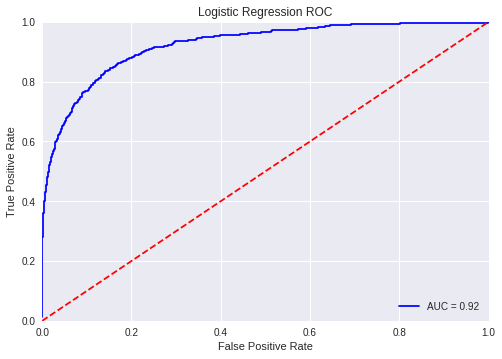

In [0]:
#y_test_pred
#y_test_prob

fpr, tpr, threshold = roc_curve(y_test, y_test_prob[:,1])
roc_auc = auc(fpr, tpr)

plt.title('Logistic Regression ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Model 2 - PCA Regression**

In [0]:
pca = pca()

X_train_pca = pca.fit_transform(X_train_num)
X_test_pca = pca.transform(X_test_num)

In [0]:
print('PCA VAF', sum(pca.explained_variance_ratio_))

PCA VAF 0.9999999999999996


Text(0.5,1,'PCA Cumulative Variance Explained')

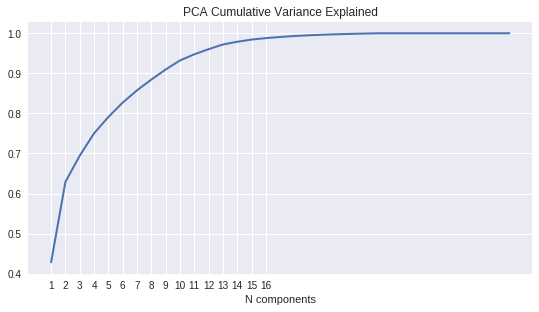

In [0]:
plt.figure(1, figsize=(10, 5))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2)
plt.axis('tight')
plt.xlabel('N components')
plt.xticks(np.arange(16), ('1', '2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21',
'22','23','24','25','26','27','28','29','30','31','32','33','34','35'))
plt.title('PCA Cumulative Variance Explained')

After PCA, we will keep the first 15 principal components.

In [0]:
#PCA = 15 components
pca_15 = pca(15)

X_train_pca_15 = pca_15.fit_transform(X_train_num)
X_test_pca_15 = pca_15.transform(X_test_num)

print('PCA VAF', sum(pca_15.explained_variance_ratio_))

PCA VAF 0.9843004387593166


In [0]:
X_train_comb_pca = np.concatenate([X_train_pca_15, X_train_cat], axis=1)
X_test_comb_pca = np.concatenate([X_test_pca_15, X_test_cat], axis=1)

In [0]:
logisticRegr_pca_15 = LogisticRegression()
logisticRegr_pca_15.fit(X_train_comb_pca, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [0]:
logisticRegr_pca_15.score(X_train_comb_pca, y_train)

0.9526055063351434

In [0]:
y_train_pred_pca_15 = logisticRegr_pca_15.predict(X_train_comb_pca)
y_test_pred_pca_15 = logisticRegr_pca_15.predict(X_test_comb_pca)
y_test_prob_pca_15 = logisticRegr_pca_15.predict_proba(X_test_comb_pca)

In [0]:
#Confusion Matrices
print(confusion_matrix(y_train, y_train_pred_pca_15))
print(confusion_matrix(y_test, y_test_pred_pca_15))

[[19216   172]
 [  823   783]]
[[8197   77]
 [ 390  334]]


In [0]:
#Classification Report
print(classification_report(y_train, y_train_pred_pca_15))
print(classification_report(y_test, y_test_pred_pca_15))

             precision    recall  f1-score   support

          0       0.96      0.99      0.97     19388
          1       0.82      0.49      0.61      1606

avg / total       0.95      0.95      0.95     20994

             precision    recall  f1-score   support

          0       0.95      0.99      0.97      8274
          1       0.81      0.46      0.59       724

avg / total       0.94      0.95      0.94      8998



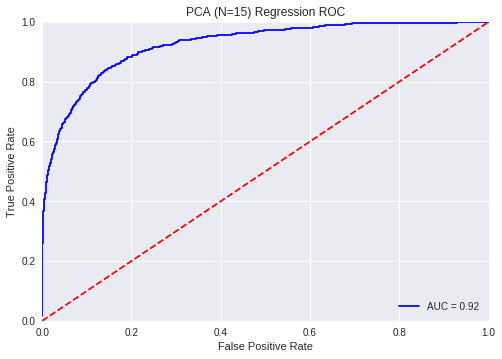

In [0]:
fpr, tpr, threshold = roc_curve(y_test, y_test_prob_pca_15[:,1])
roc_auc = auc(fpr, tpr)

plt.title('PCA (N=15) Regression ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()